# Generating OBC and IC for CCS1 from global MOM6 model output

*Contribution of Raphael Dussin*

First let's describe the packages we're using:

 * xarray: if you're not familiar, better catch up http://xarray.pydata.org/en/stable/
 * xesmf: xarray-friendly horizontal remapping based on ESMF library. We will use it to remap data onto boundaries and regional domain. https://xesmf.readthedocs.io/en/latest/
 * HCtFlood: horizontal 2D extrapolation package, used to replace NaN on land by closest ocean value. https://github.com/raphaeldussin/HCtFlood
 * bottleneck: optimized compute kernels, needed for xr.ffill or xr.bfill. Make sure to have it installed (available through conda/pip)
 * GFDL_xr: only a wrapper to xarray open functions with embedded retrieve from tape, can be replaced by xr if not at GFDL. https://github.com/raphaeldussin/GFDL_xr

In [1]:
import xarray as xr
import xesmf
from HCtFlood.kara import flood_kara
import bottleneck
import GFDL_xr

## 1. Loading MOM6 model output from the global model

First step is to load data from the global model, including the metrics and merge the whole thing into a dataset:

In [2]:
dirdata = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/OM4p25_JRA55do1.4_0netfw_cycle6/gfdl.ncrc4-intel16-prod/pp/'

In [3]:
dsgrid = GFDL_xr.open_dataset(dirdata + 'ocean_monthly_z/ocean_monthly_z.static.nc', decode_times=False)

In [4]:
ds = GFDL_xr.open_mfdataset(dirdata + 'ocean_monthly_z/ts/monthly/5yr/ocean_monthly_z.*.thetao.nc',
                            decode_times=False, combine='by_coords')

In [5]:
ds = xr.merge([ds, dsgrid])

In [6]:
ds

<xarray.Dataset>
Dimensions:       (nv: 2, time: 720, xh: 1440, xq: 1440, yh: 1080, yq: 1080, z_i: 36, z_l: 35)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * time          (time) float64 15.5 45.0 74.5 ... 2.184e+04 2.187e+04 2.19e+04
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    average_DT    (time) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1    (time) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2    (time) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    thetao        (time, z_l, yh, xh) float32 dask.array<chunksize=(60, 35, 1080, 1440), meta=np.ndarray>
    time_bnds     (time, nv) float64 dask.array<chunksize=(60, 2), meta=np.ndarray>
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
    areacello_cu  (yh, xq) float32 ...
    areacello_cv  (yq, xh) float32 ...
    deptho        (yh, xh) float32 ...
    dxCu          (yh, xq) float32 ...
    dxCv          (yq, xh) float32 ...
    dxt           (yh, xh) float32 ...
    dyCu          (yh, xq) float32 ...
    dyCv          (yq, xh) float32 ...
    dyt           (yh, xh) float32 ...
    geolat        (yh, xh) float32 ...
    geolat_c      (yq, xq) float32 ...
    geolat_u      (yh, xq) float32 ...
    geolat_v      (yq, xh) float32 ...
    geolon        (yh, xh) float32 ...
    geolon_c      (yq, xq) float32 ...
    geolon_u      (yh, xq) float32 ...
    geolon_v      (yq, xh) float32 ...
    hfgeou        (yh, xh) float32 ...
    sftof         (yh, xh) float32 ...
    wet           (yh, xh) float32 ...
    wet_c         (yq, xq) float32 ...
    wet_u         (yh, xq) float32 ...
    wet_v         (yq, xh) float32 ...

## 2. Loading the regional grid

Then load the target regional grid. In this case, we're using the supergrid but a staggered grid can also be used. Just be mindful of what coordinates you're using for the remapping. 

In [7]:
ds_ccs = xr.open_dataset('ocean_hgrid_ccs1.nc')

In [8]:
ds_ccs

<xarray.Dataset>
Dimensions:   (nx: 360, nxp: 361, ny: 960, nyp: 961)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    angle_dx  (nyp, nxp) float32 ...
    y         (nyp, nxp) float32 ...
    x         (nyp, nxp) float32 ...
    dx        (nyp, nx) float32 ...
    dy        (ny, nxp) float32 ...
    area      (ny, nx) float32 ...
    tile      |S5 ...
Attributes:
    history:  Mon Jul 11 14:52:29 2016: ncatted -a units,y,m,c,degree_north o...
    NCO:      "4.5.5"

## 3. Subsetting the domain 

For computational efficiency, we are going to take a subset of the global grid so we reduce the size of the remapping matrix.
The whole domain is order nx * ny = 1500 x 1000 points:

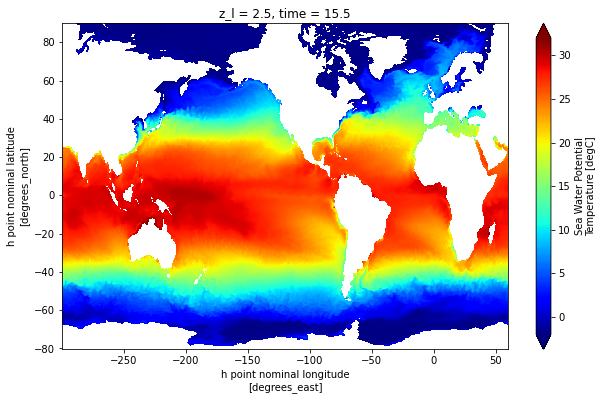

In [9]:
ds['thetao'].isel(time=0, z_l=0).plot(figsize=[10,6], vmin=-2, vmax=32, cmap='jet')

We can easily cut a subset around the region of interest (no need to be super precise):

In [10]:
ds_cut = ds.sel(xh=slice(-150, -100), yh=slice(15,55),
                xq=slice(-150, -100), yq=slice(15,55))

and now we're down to roughly nx * ny = 200 x 200 points:

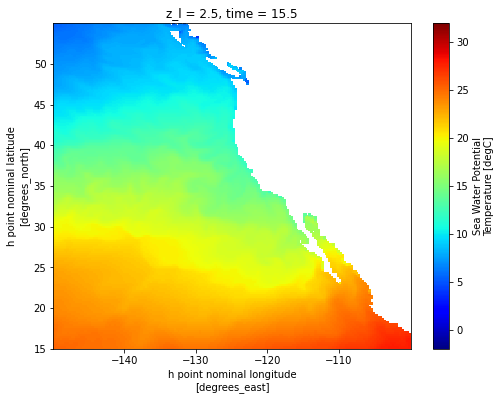

In [11]:
ds_cut['thetao'].isel(time=0, z_l=0).plot(figsize=[8, 6], vmin=-2, vmax=32, cmap='jet')

## 4. Regridding to Open Boundaries

We define our boundaries as xarray.Dataset and slice coordinates for each side of the domain with ocean values:

In [12]:
# northern boundary
north = xr.Dataset()
north['lon'] = ds_ccs['x'].isel(nyp=-1)
north['lat'] = ds_ccs['y'].isel(nyp=-1)

# southern boundary
south = xr.Dataset()
south['lon'] = ds_ccs['x'].isel(nyp=0)
south['lat'] = ds_ccs['y'].isel(nyp=0)

# western boundary
west = xr.Dataset()
west['lon'] = ds_ccs['x'].isel(nxp=0)
west['lat'] = ds_ccs['y'].isel(nxp=0)

Using xESMF we can create regridding weights from our subset of the global domain to the different boundaries.
A few important things to mention here:

 * xesmf requires input datasets coordinates to be named lon/lat, hence the renaming of coordinates. Make sure you're using the coordinate that correspond to the location of your variable on the staggered grid
 * since we're using a subset, we need to set the periodicity to False
 * we're using the locstream option alloaing to remap directly to a segment. More info here: https://xesmf.readthedocs.io/en/latest/notebooks/Using_LocStream.html
 
The weight generation for tracer data onto the 3 open boudaries are then:

In [13]:
regrid_north = xesmf.Regridder(ds_cut.rename({'geolon': 'lon', 'geolat': 'lat'}), north, 'bilinear', 
                               locstream_out=True, periodic=False, filename='regrid_north.nc')

Create weight file: regrid_north.nc


In [14]:
regrid_south = xesmf.Regridder(ds_cut.rename({'geolon': 'lon', 'geolat': 'lat'}), south, 'bilinear', 
                               locstream_out=True, periodic=False, filename='regrid_south.nc')

Create weight file: regrid_south.nc


In [15]:
regrid_west = xesmf.Regridder(ds_cut.rename({'geolon': 'lon', 'geolat': 'lat'}), west, 'bilinear', 
                              locstream_out=True, periodic=False, filename='regrid_west.nc')

Create weight file: regrid_west.nc


Remapping the temperature onto the northern boundary can then be performed lazily using the appropriate xESMF regridder:

In [16]:
temp_north = regrid_north(ds_cut['thetao'])

We can examine the result for the first time record:

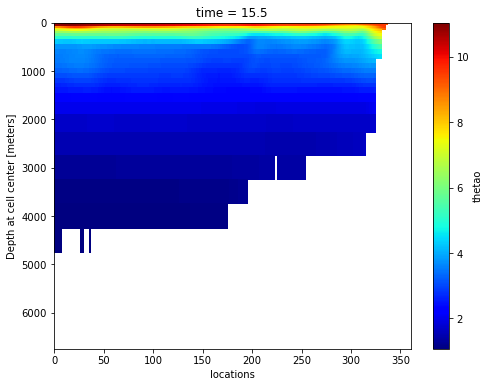

In [17]:
temp_north.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

Now let's remove the missing values to make sure we don't have problems with the inconsistency between the coarse global and high resolution regional bathymetries.
We can easily perform this operation using xarray ffill (forward fill) or bfill (backward fill), that come from bottleneck. Forward or backward are relative to the
array indexing. In this case, we're going to fill forward along locations then forward in depth (surface is index 0):

In [18]:
drowned_temp_north = temp_north.ffill(dim='locations').ffill(dim='z_l')

Note that we're still working lazily. We can look at a snapshot to check our computation:

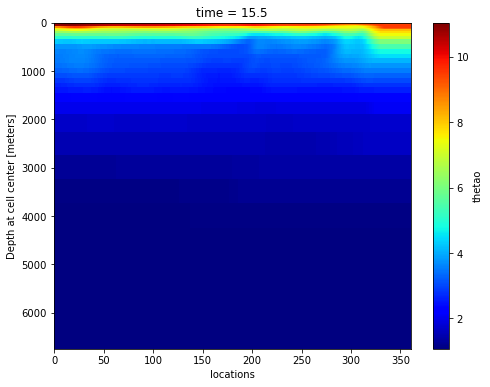

In [19]:
drowned_temp_north.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

Beautiful!! Now repeat for the other boundaries:

In [20]:
temp_south = regrid_south(ds_cut['thetao'])

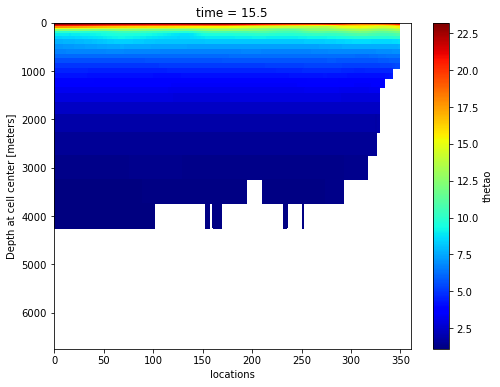

In [21]:
temp_south.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

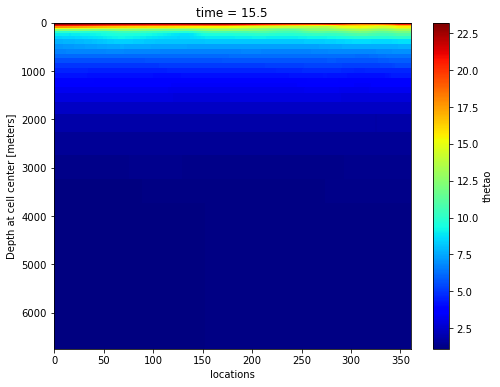

In [22]:
drowned_temp_south = temp_south.ffill(dim='locations').ffill(dim='z_l')
drowned_temp_south.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

In [23]:
temp_west = regrid_west(ds_cut['thetao'])

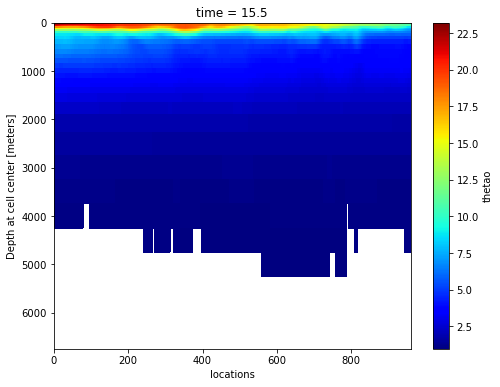

In [24]:
temp_west.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

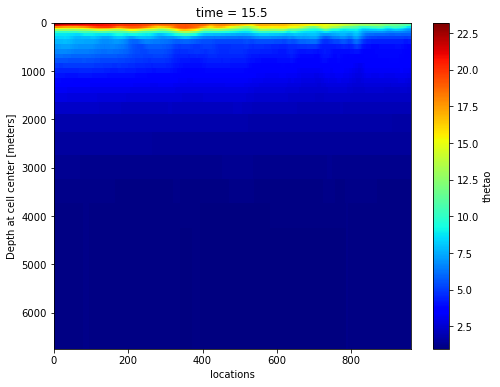

In [25]:
drowned_temp_west = temp_west.ffill(dim='z_l')
drowned_temp_west.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

Final step is to run computations eagerly (use a dask cluster for speed) and package into a netcdf file.

## 5. Initial conditions

Now let's look at how we can create initial conditions for temperature. First we need a xESMF regridder for the whole domain:

In [26]:
regrid_domain = xesmf.Regridder(ds_cut.rename({'geolon': 'lon', 'geolat': 'lat'}), ds_ccs.rename({'x': 'lon', 'y': 'lat'}), 'bilinear', 
                                periodic=False, filename='regrid_domain.nc')

Create weight file: regrid_domain.nc


Before remapping we're going to extrapolate ocean values onto land, again to deal with inconsistencies between global and regional bathymetry data.
But instead of using xarray ffill/bfill, which only work along one axis at the time, we're gonna use a bidimensional extrapolation algo from Kara et al.
The extrapolation has been re-coded in python, optimized with numba and wrapped for xarray/dask lazy operation in [HCtFlood](https://github.com/raphaeldussin/HCtFlood): 

In [27]:
drowned_temp = flood_kara(ds_cut['thetao'], xdim='xh', ydim='yh', zdim='z_l')

Let's examine the result:

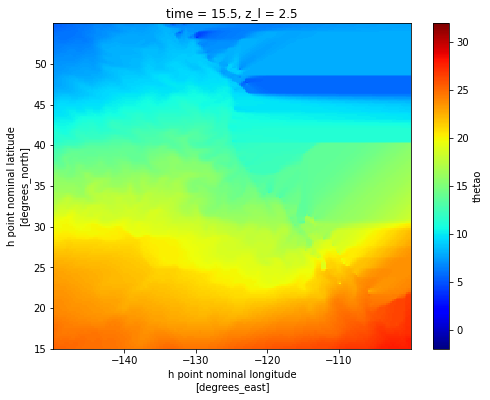

In [28]:
drowned_temp.isel(time=0, z_l=0).plot(figsize=[8, 6], vmin=-2, vmax=32, cmap='jet')

Now one thing to be careful is that some levels at the bottom can have no ocean values to extrapolate.
In this case, the flood algo does not change the values. For example, in our configuration, only the bottom level is empty:

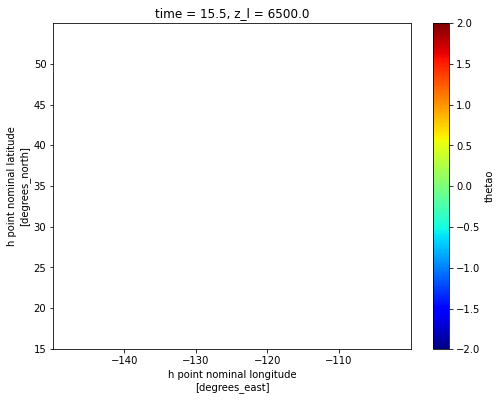

In [29]:
drowned_temp.isel(time=0, z_l=34).plot(figsize=[8, 6], vmin=-2, vmax=2, cmap='jet')

This can be easily resolved by extrapolating along the vertical axis, the values for the N-1 level using xr.ffill:

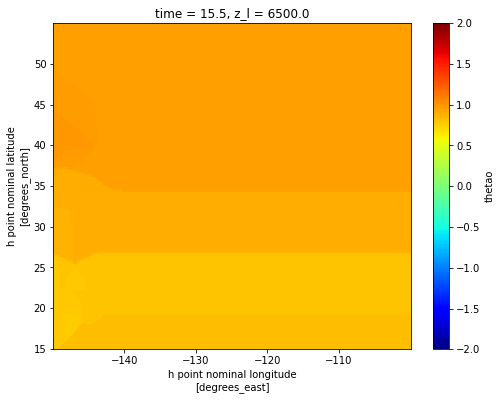

In [30]:
alldrowned_temp = drowned_temp.ffill(dim='z_l')

alldrowned_temp.isel(time=0, z_l=34).plot(figsize=[8, 6], vmin=-2, vmax=2, cmap='jet')

Now we can remap onto the regional domain grid:

In [31]:
temp_ic_ccs = regrid_domain(alldrowned_temp)

In [32]:
temp_ic_ccs

<xarray.DataArray 'thetao' (time: 720, z_l: 35, nyp: 961, nxp: 361)>
dask.array<regrid_numpy, shape=(720, 35, 961, 361), dtype=float64, chunksize=(1, 35, 961, 361), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 15.5 45.0 74.5 ... 2.184e+04 2.187e+04 2.19e+04
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lon      (nyp, nxp) float32 239.18677 239.21523 ... 233.27739 233.31824
    lat      (nyp, nxp) float32 18.657413 18.671423 ... 50.278313 50.2939
Dimensions without coordinates: nyp, nxp
Attributes:
    regrid_method:  bilinear

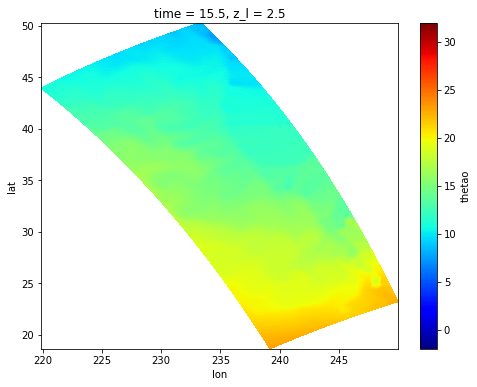

In [33]:
temp_ic_ccs.isel(time=0, z_l=0).plot(figsize=[8, 6], x='lon', y='lat', vmin=-2, vmax=32, cmap='jet')

Happy regional modeling!!